# NYC Soundscape  EDA

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path

plt.rcParams.update({
    'figure.facecolor': '#070810',
    'axes.facecolor':   '#0d0f1a',
    'axes.edgecolor':   '#1e2240',
    'axes.labelcolor':  '#e8eaf6',
    'xtick.color':      '#5a5f8a',
    'ytick.color':      '#5a5f8a',
    'text.color':       '#e8eaf6',
    'grid.color':       '#1e2240',
    'grid.linewidth':   0.5,
})

SC = {
    'engine':    '#ff6b6b',
    'machinery': '#ff9f43',
    'impact':    '#ffd32a',
    'saw':       '#26de81',
    'alert':     '#fd79a8',
    'music':     '#a29bfe',
    'voice':     '#74b9ff',
    'dog':       '#55efc4',
}

COARSE_MAP = {
    '1_engine_presence':               'engine',
    '2_machinery-impact_presence':     'machinery',
    '3_non-machinery-impact_presence': 'impact',
    '4_powered-saw_presence':          'saw',
    '5_alert-signal_presence':         'alert',
    '6_music_presence':                'music',
    '7_human-voice_presence':          'voice',
    '8_dog_presence':                  'dog',
}

BOROUGH_NAMES = {'1': 'Manhattan', '3': 'Brooklyn', '4': 'Queens'}

csv = Path('../data/metadata/annotations.csv')
df = pd.read_csv(csv, low_memory=False)
df['borough_name'] = df['borough'].astype(str).map(BOROUGH_NAMES)
df['annotator_type'] = df['annotator_id'].apply(
    lambda x: 'ground_truth' if x == 0 else ('sonyc_team' if x < 0 else 'zooniverse')
)
print(f'Rows: {len(df):,}   Columns: {df.shape[1]}')
df.head(3)

Rows: 62,022   Columns: 80


,split,sensor_id,audio_filename,annotator_id,borough,block,latitude,longitude,year,week,...,1_engine_presence,2_machinery-impact_presence,3_non-machinery-impact_presence,4_powered-saw_presence,5_alert-signal_presence,6_music_presence,7_human-voice_presence,8_dog_presence,borough_name,annotator_type
0,test,0,00_026884.wav,-6,1,547,40.72951,-73.99388,2019,43,...,-1,1,0,-1,-1,-1,-1,-1,Manhattan,sonyc_team
1,test,0,00_026884.wav,-4,1,547,40.72951,-73.99388,2019,43,...,1,-1,-1,-1,-1,-1,-1,-1,Manhattan,sonyc_team
2,test,0,00_026884.wav,-3,1,547,40.72951,-73.99388,2019,43,...,1,-1,-1,-1,-1,-1,-1,-1,Manhattan,sonyc_team


## Schema overview

In [88]:
fine_presence  = [c for c in df.columns if '_presence' in c and c[0].isdigit() and '-' in c]
coarse_presence= [c for c in df.columns if '_presence' in c and c[0].isdigit() and '-' not in c]
proximity_cols = [c for c in df.columns if '_proximity' in c]

print(f'Coarse presence cols : {len(coarse_presence)}')
print(f'Fine presence cols   : {len(fine_presence)}')
print(f'Proximity cols       : {len(proximity_cols)}')
print()
# Value distribution: 0 / 1 / -1
val_counts = {}
for c in coarse_presence:
    vc = df[c].value_counts().to_dict()
    val_counts[c.replace('_presence','')] = vc

vc_df = pd.DataFrame(val_counts).T.fillna(0).astype(int)
vc_df.columns = [str(c) for c in vc_df.columns]
print('Value counts (0=absent, 1=present, -1=unlabeled by this annotator):')
vc_df

Coarse presence cols : 3
Fine presence cols   : 34
Proximity cols       : 29

Value counts (0=absent, 1=present, -1=unlabeled by this annotator):


,0,1,-1
1_engine,40202,18184,3636
6_music,54056,3102,4864
8_dog,54570,2472,4980


## Coverage

In [89]:
print('Split distribution:')
print(df['split'].value_counts().to_string())
print()
print('Borough (1=Manhattan 3=Brooklyn 4=Queens):')
print(df['borough'].value_counts().sort_index().to_string())
print()
print('Annotator type:')
print(df['annotator_type'].value_counts().to_string())
print()
print(f"Unique sensors : {df['sensor_id'].nunique()}")
print(f"Unique clips   : {df['audio_filename'].nunique()}")
print(f"Year range     : {df['year'].min()} - {df['year'].max()}")
print(f"Hour range     : {df['hour'].min()} - {df['hour'].max()}")

Split distribution:
split
train       41444
validate    15336
test         5242

Borough (1=Manhattan 3=Brooklyn 4=Queens):
borough
1    58527
3     3356
4      139

Annotator type:
annotator_type
zooniverse      55530
sonyc_team       5112
ground_truth     1380

Unique sensors : 56
Unique clips   : 18510
Year range     : 2016 - 2019
Hour range     : 0 - 23


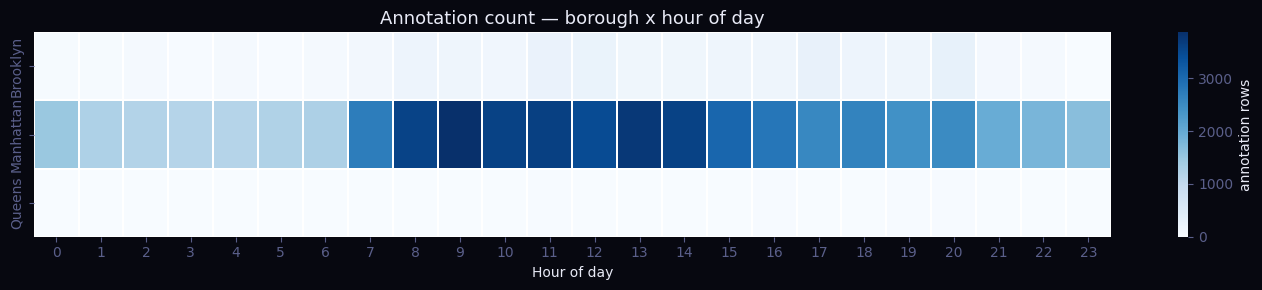

In [90]:
# Annotation count heatmap: borough x hour
pivot = (df[df['borough_name'].notna()]
         .groupby(['borough_name','hour'])
         .size().unstack(fill_value=0))

fig, ax = plt.subplots(figsize=(14, 3))
sns.heatmap(pivot, ax=ax, cmap='Blues', linewidths=0.3,
            cbar_kws={'label': 'annotation rows'})
ax.set_title('Annotation count — borough x hour of day', fontsize=13)
ax.set_xlabel('Hour of day')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

## Sound prevelance (how often they show up)

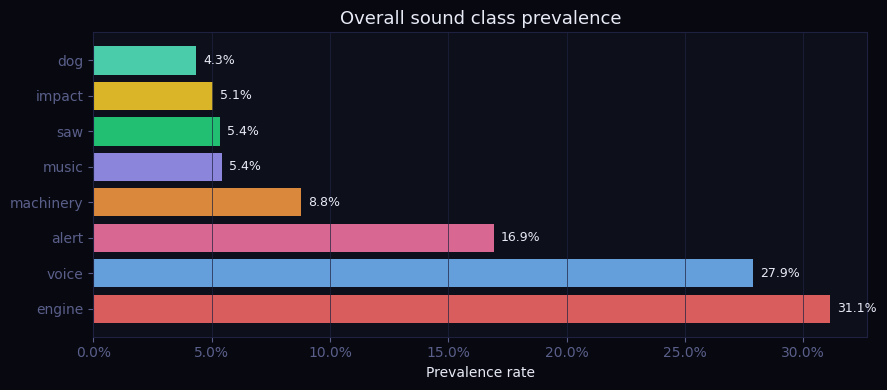

In [91]:
# clean coarse-presence frame: replace -1 with NaN
cp = df[list(COARSE_MAP.keys())].replace(-1, np.nan).rename(columns=COARSE_MAP).copy()
cp['hour'] = df['hour']
cp['borough_name'] = df['borough_name']
sounds = list(COARSE_MAP.values())

overall = cp[sounds].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(9, 4))
bars = ax.barh(overall.index, overall.values,
               color=[SC[k] for k in overall.index], alpha=0.85)
ax.set_xlabel('Prevalence rate')
ax.set_title('Overall sound class prevalence', fontsize=13)
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.grid(axis='x')
for bar, val in zip(bars, overall.values):
    ax.text(val + 0.003, bar.get_y() + bar.get_height()/2,
            f'{val:.1%}', va='center', fontsize=9)
plt.tight_layout()
plt.show()

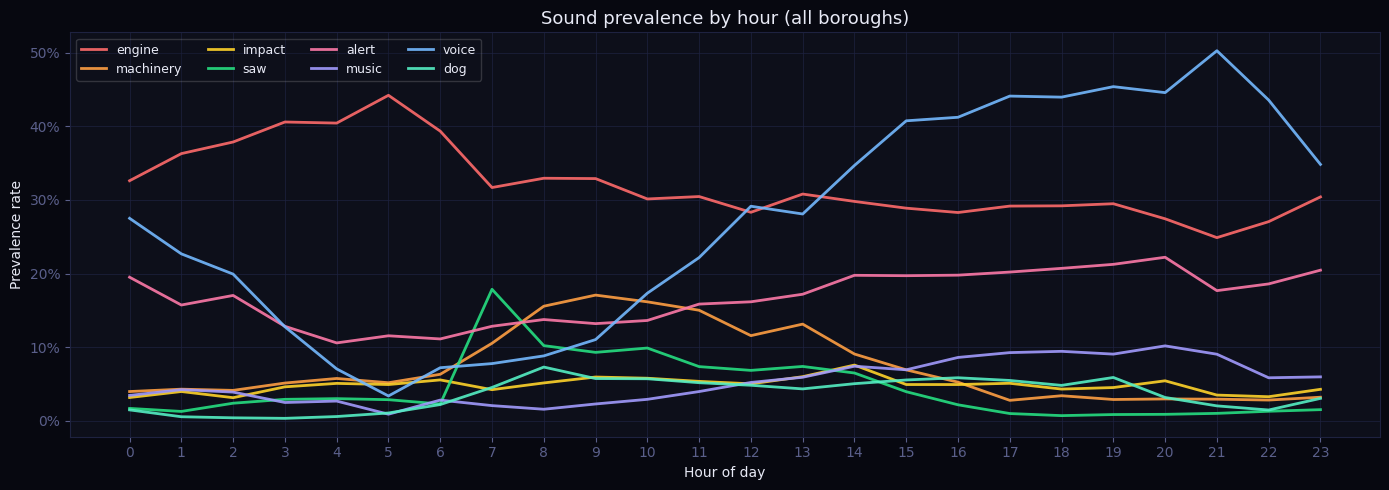

In [92]:
# Prevalence by hour — global
hourly = cp.groupby('hour')[sounds].mean()

fig, ax = plt.subplots(figsize=(14, 5))
for sound, color in SC.items():
    ax.plot(hourly.index, hourly[sound], color=color,
            linewidth=2, label=sound, alpha=0.9)
ax.set_xlabel('Hour of day')
ax.set_ylabel('Prevalence rate')
ax.set_title('Sound prevalence by hour (all boroughs)', fontsize=13)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.set_xticks(range(24))
ax.legend(loc='upper left', framealpha=0.2, fontsize=9, ncol=4)
ax.grid()
plt.tight_layout()
plt.show()

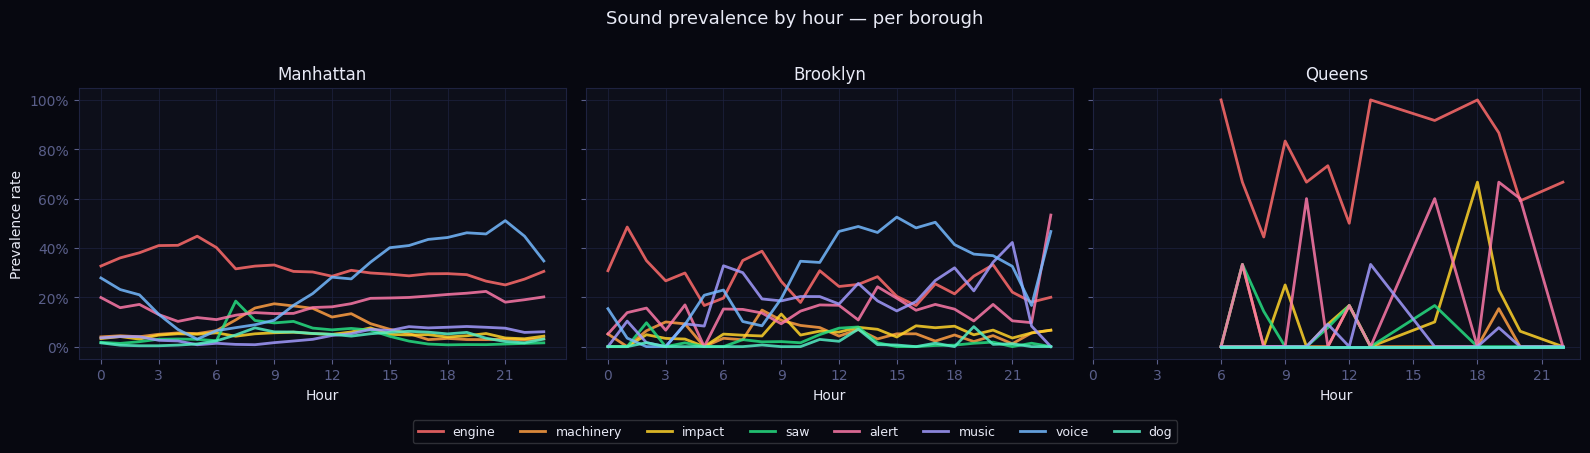

In [93]:
# Prevalence by borough x hour — small multiples
boroughs = ['Manhattan', 'Brooklyn', 'Queens']
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for ax, bname in zip(axes, boroughs):
    sub = cp[cp['borough_name'] == bname].groupby('hour')[sounds].mean()
    for sound, color in SC.items():
        ax.plot(sub.index, sub[sound], color=color,
                linewidth=2, label=sound, alpha=0.85)
    ax.set_title(bname, fontsize=12)
    ax.set_xlabel('Hour')
    ax.set_xticks(range(0, 24, 3))
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    ax.grid()

axes[0].set_ylabel('Prevalence rate')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=8,
           framealpha=0.2, fontsize=9, bbox_to_anchor=(0.5, -0.08))
fig.suptitle('Sound prevalence by hour — per borough', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## Sensor map

Sensor count by borough:
borough_name
Manhattan    43
Brooklyn     12
Queens        1
Total: 56 sensors


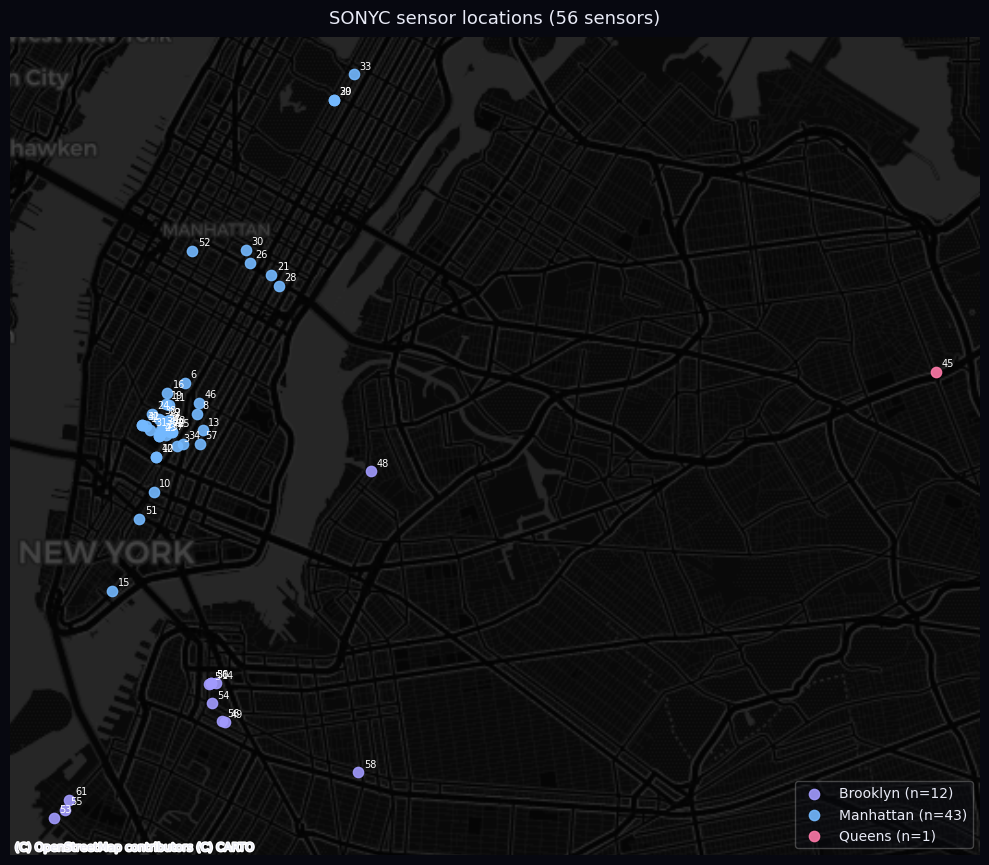

In [94]:
import contextily as ctx
import geopandas as gpd

sensors = (df[["sensor_id","latitude","longitude","borough_name"]]
           .drop_duplicates("sensor_id").dropna())

counts = sensors["borough_name"].value_counts()
print("Sensor count by borough:")
print(counts.to_string())
print(f"Total: {len(sensors)} sensors")

borough_colors = {"Manhattan": "#74b9ff", "Brooklyn": "#a29bfe", "Queens": "#fd79a8"}

gdf = gpd.GeoDataFrame(
    sensors,
    geometry=gpd.points_from_xy(sensors["longitude"], sensors["latitude"]),
    crs="EPSG:4326",
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 12))

for bname, grp in gdf.groupby("borough_name"):
    grp.plot(ax=ax, color=borough_colors[bname], markersize=55,
             alpha=0.9, zorder=4, label=f"{bname} (n={len(grp)})")
    for _, row in grp.iterrows():
        ax.annotate(str(int(row["sensor_id"])),
                    (row.geometry.x, row.geometry.y),
                    fontsize=7, color="white",
                    xytext=(4, 4), textcoords="offset points", zorder=5)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter, zoom=12)
ax.set_axis_off()
ax.set_title(f"SONYC sensor locations ({len(sensors)} sensors)",
             fontsize=13, color="#e8eaf6", pad=10)
ax.legend(framealpha=0.3, fontsize=10, loc="lower right")
fig.patch.set_facecolor("#070810")
plt.tight_layout()
plt.show()


## Fine-grained classes breakdown

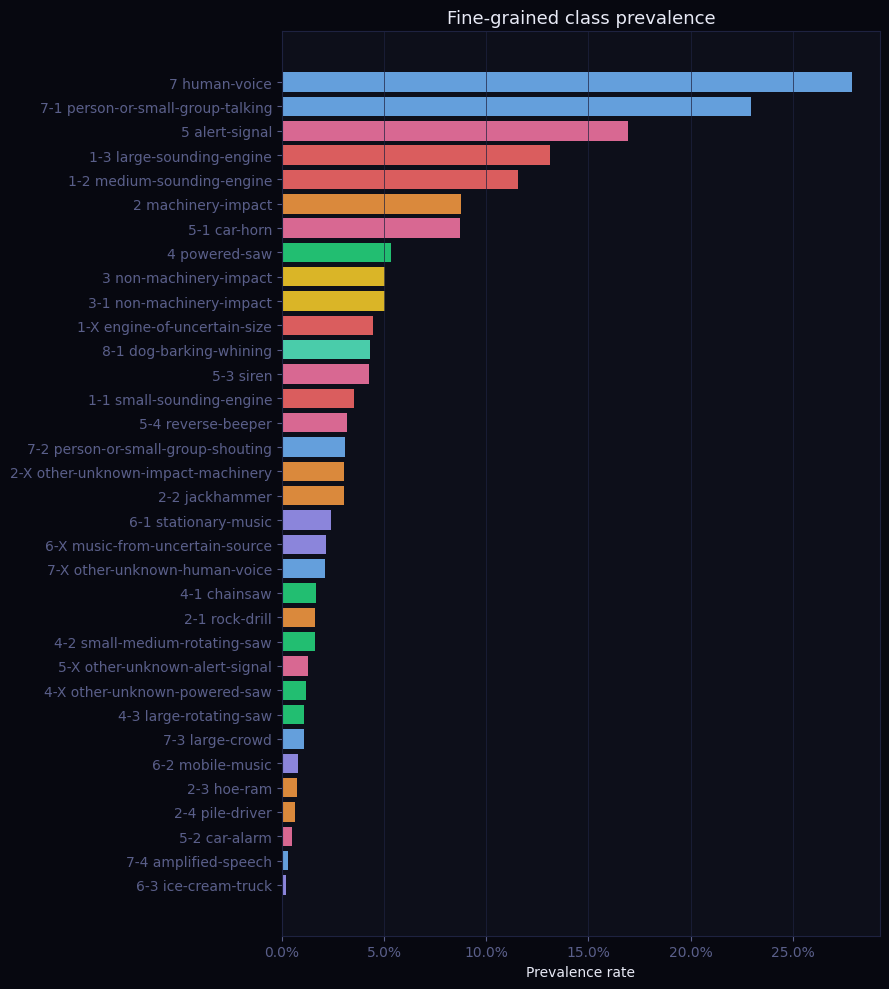

In [95]:
fine = df[fine_presence].replace(-1, np.nan)
fine_prev = fine.mean().sort_values(ascending=True)

def coarse_color(col_name):
    prefix = col_name.split('_')[0].split('-')[0]
    mapping = {'1':'engine','2':'machinery','3':'impact','4':'saw',
               '5':'alert','6':'music','7':'voice','8':'dog'}
    return SC.get(mapping.get(prefix, ''), '#888')

colors = [coarse_color(c) for c in fine_prev.index]
labels = [c.replace('_presence','').replace('_',' ') for c in fine_prev.index]

fig, ax = plt.subplots(figsize=(9, 10))
ax.barh(labels, fine_prev.values, color=colors, alpha=0.85)
ax.set_xlabel('Prevalence rate')
ax.set_title('Fine-grained class prevalence', fontsize=13)
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.grid(axis='x')
plt.tight_layout()
plt.show()

## Zone analysis

WSP sensors    (<1.0km): 32 sensors, 53,297 annotations
Tandon sensors (<1.0km): 7 sensors, 2,954 annotations
Queens sensors           : 1 sensor,  139 annotations


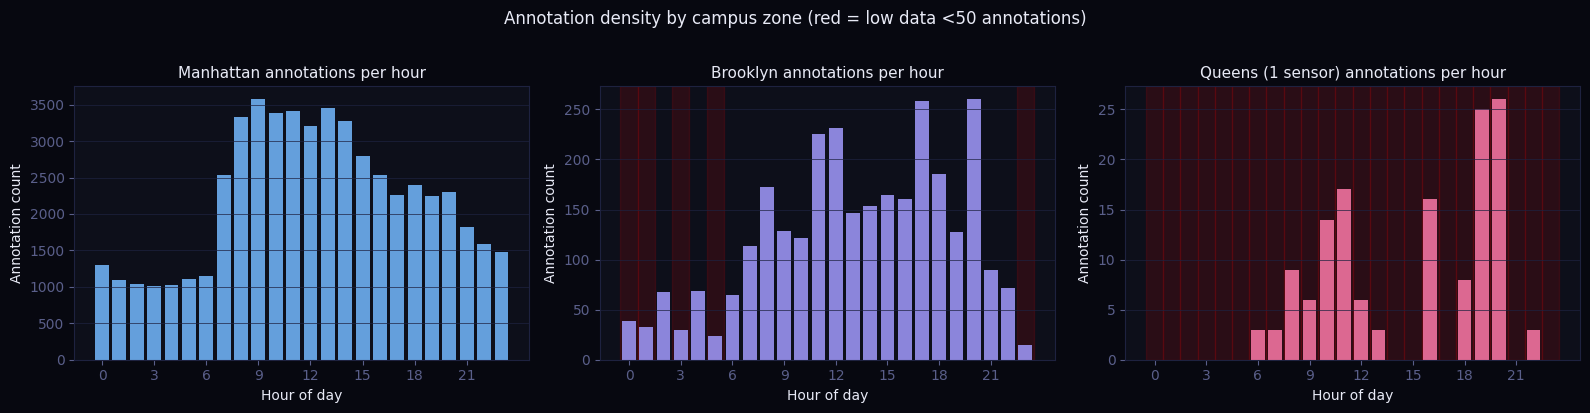

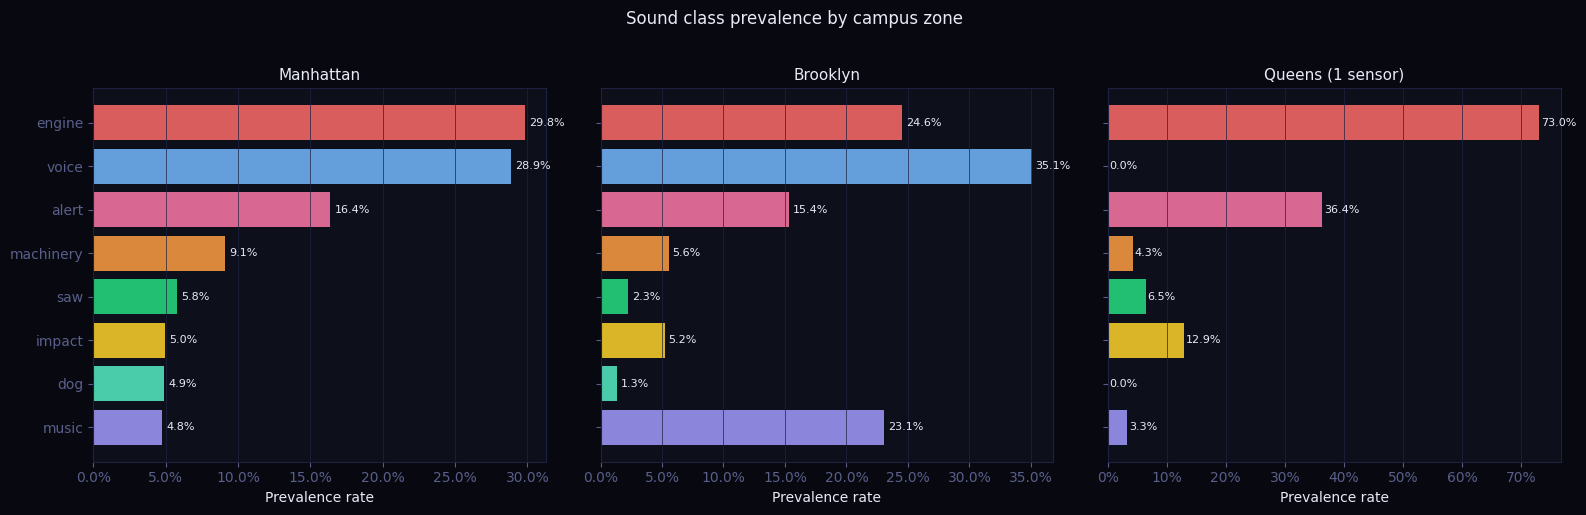

In [96]:
import numpy as np

def dist_km(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2-lat1); dlon = np.radians(lon2-lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

WSP    = (40.7308, -73.9973)
TANDON = (40.6942, -73.9865)
RADIUS_KM = 1.0

sensors = (df[["sensor_id","latitude","longitude","borough_name"]]
           .drop_duplicates("sensor_id").dropna())
sensors["dist_wsp"]    = sensors.apply(lambda r: dist_km(r.latitude, r.longitude, *WSP), axis=1)
sensors["dist_tandon"] = sensors.apply(lambda r: dist_km(r.latitude, r.longitude, *TANDON), axis=1)

wsp_ids    = sensors[sensors["dist_wsp"]    < RADIUS_KM]["sensor_id"].tolist()
tandon_ids = sensors[sensors["dist_tandon"] < RADIUS_KM]["sensor_id"].tolist()
queens_ids = sensors[sensors["borough_name"] == "Queens"]["sensor_id"].tolist()

wsp_data    = df[df["sensor_id"].isin(wsp_ids)]
tandon_data = df[df["sensor_id"].isin(tandon_ids)]
queens_data = df[df["sensor_id"].isin(queens_ids)]

print(f"WSP sensors    (<{RADIUS_KM}km): {len(wsp_ids)} sensors, {len(wsp_data):,} annotations")
print(f"Tandon sensors (<{RADIUS_KM}km): {len(tandon_ids)} sensors, {len(tandon_data):,} annotations")
print(f"Queens sensors           : {len(queens_ids)} sensor,  {len(queens_data):,} annotations")

zone_data = [
    (wsp_data,    "Manhattan",           "#74b9ff"),
    (tandon_data, "Brooklyn",        "#a29bfe"),
    (queens_data, "Queens (1 sensor)", "#fd79a8"),
]

# ── Plot 1: annotations per hour ─────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=False)
for (data, label, color), ax in zip(zone_data, axes):
    counts = data.groupby("hour").size().reindex(range(24), fill_value=0)
    ax.bar(counts.index, counts.values, color=color, alpha=0.85, width=0.8)
    ax.set_title(f"{label} annotations per hour", fontsize=11)
    ax.set_xlabel("Hour of day")
    ax.set_ylabel("Annotation count")
    ax.set_xticks(range(0, 24, 3))
    ax.grid(axis="y")
    for h, n in counts.items():
        if n < 50:
            ax.axvspan(h - 0.5, h + 0.5, color="red", alpha=0.12, zorder=0)
fig.suptitle("Annotation density by campus zone (red = low data <50 annotations)",
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# ── Plot 2: sound prevalence by zone ─────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
for (data, label, color), ax in zip(zone_data, axes):
    cp_zone = data[list(COARSE_MAP.keys())].replace(-1, np.nan).rename(columns=COARSE_MAP)
    prev = cp_zone.mean().sort_values(ascending=True)
    bars = ax.barh(prev.index, prev.values,
                   color=[SC[k] for k in prev.index], alpha=0.85)
    ax.set_title(label, fontsize=11)
    ax.set_xlabel("Prevalence rate")
    ax.xaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
    ax.grid(axis="x")
    for bar, val in zip(bars, prev.values):
        ax.text(val + 0.003, bar.get_y() + bar.get_height()/2,
                f"{val:.1%}", va="center", fontsize=8)
fig.suptitle("Sound class prevalence by campus zone", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()


## Scratch pad

In [97]:
# engine prevalence by annotator type
eng = df.groupby('annotator_type')['1_engine_presence'].apply(
    lambda x: x[x != -1].mean()
)
print('Engine prevalence by annotator type:')
print(eng)

Engine prevalence by annotator type:
annotator_type
ground_truth    0.530435
sonyc_team      0.797425
zooniverse      0.293085
Name: 1_engine_presence, dtype: float64


In [98]:
# Your turn
